### Analysis of bike sharing rentals in Washington, DC.

Data set and data dictionary is found here:
http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [310]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

# drop irrelevant columns
bike_rentals.drop(columns=['instant', 'temp'], inplace=True)

In [311]:
# Combine month and year into one column
bike_rentals['year_month'] = (bike_rentals['yr'] * 12) + bike_rentals['mnth']

In [312]:
print(bike_rentals.shape)
bike_rentals.head()

(17379, 16)


,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,casual,registered,cnt,year_month
0,2011-01-01,1,0,1,0,0,6,0,1,0.2879,0.81,0.0,3,13,16,1
1,2011-01-01,1,0,1,1,0,6,0,1,0.2727,0.80,0.0,8,32,40,1
2,2011-01-01,1,0,1,2,0,6,0,1,0.2727,0.80,0.0,5,27,32,1
3,2011-01-01,1,0,1,3,0,6,0,1,0.2879,0.75,0.0,3,10,13,1
4,2011-01-01,1,0,1,4,0,6,0,1,0.2879,0.75,0.0,0,1,1,1


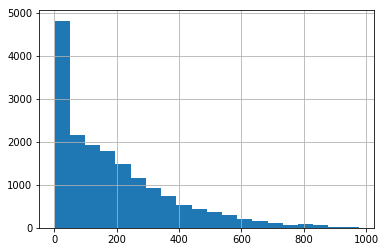

In [313]:
bike_rentals['cnt'].hist(bins=20)

In [314]:
bike_rentals.corr().sort_values(by='cnt', ascending=False)[['cnt']]

,cnt
cnt,1.000000
registered,0.972151
casual,0.694564
atemp,0.400929
hr,0.394071
year_month,0.278580
yr,0.250495
season,0.178056
mnth,0.120638
windspeed,0.093234


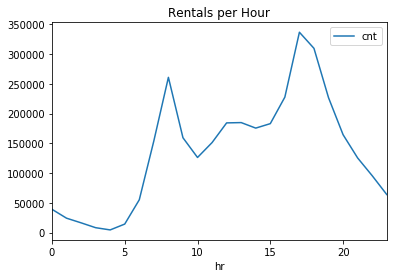

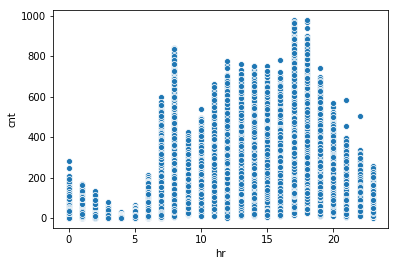

In [315]:
bike_rentals.groupby('hr').agg('sum')[['cnt']].plot.line(title='Rentals per Hour')
plt.show()

sns.scatterplot(x=bike_rentals['hr'], y=bike_rentals['cnt'])

Hour of the day is very highly correlated with the number of rentals.  Let's see what happens if we group these into times of day.

time_of_day    0.385600
hr             0.394071
cnt            1.000000
Name: cnt, dtype: float64


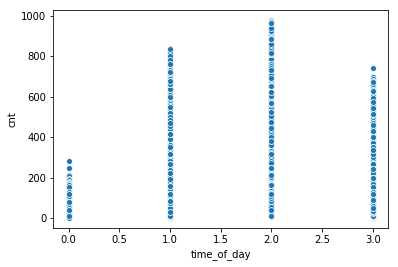

In [316]:
def time_label(hr):
    return int((hr - 1) / 6)

bike_rentals['time_of_day'] = bike_rentals['hr'].apply(time_label)

print(bike_rentals[['time_of_day','hr','cnt']].corr()['cnt'])

sns.scatterplot(x=bike_rentals['time_of_day'], y=bike_rentals['cnt'])

Hour is actually more correlated with rentals than the generic time of day, but we'll leave "time_of_day" and see how it affects the model.

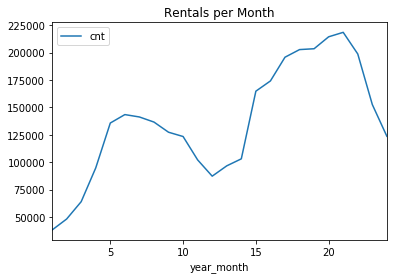

In [317]:
bike_rentals.groupby('year_month').agg('sum')[['cnt']].plot.line(title='Rentals per Month')

Rentals are increasing significantly year to year.  Growth!

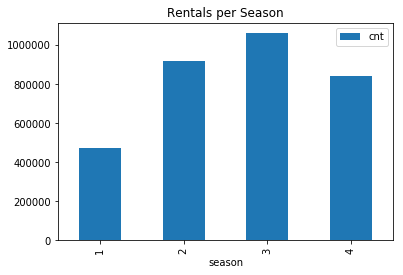

In [318]:
bike_rentals.groupby('season').agg('sum')[['cnt']].plot.bar(title='Rentals per Season')

Surprisingly, spring has the least number of rentals.  This could be due to the increase in rentals over time, as rentals from December of the second year at the same as June of the first year.  Temperature is probably a more important factor.

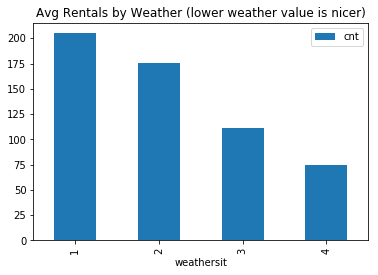

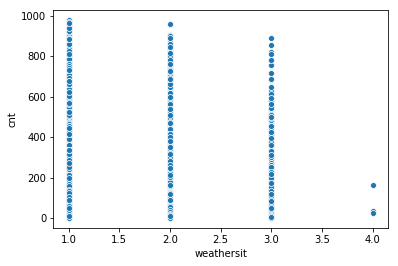

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64

In [319]:
bike_rentals.groupby('weathersit').agg('mean')[['cnt']].plot.bar(title='Avg Rentals by Weather (lower weather value is nicer)')
plt.show()

sns.scatterplot(x=bike_rentals['weathersit'], y=bike_rentals['cnt'])
plt.show()

# As the numerical value increases, the weather gets worse (more rain/snow)
bike_rentals['weathersit'].value_counts()

Not surprisingly, people like to bike in good weather.  We don't have a lot of data about really bad weather though, so that data may not be super helpful.  That being said, we all know riding in a thunderstorm is no fun, so we'll keep it.  Surprisingly, weather is not very highly correlated with the number of rentals.

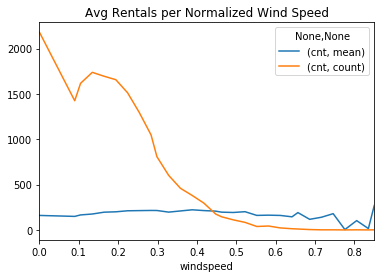

In [320]:
bike_rentals.groupby('windspeed').agg(['mean', 'count'])[['cnt']].plot.line(title='Avg Rentals per Normalized Wind Speed')

Wind doesn't really become much of a factor unless we have high winds.  We'll create a boolean column to specify whether it's significantly windy or not.

In [321]:
bike_rentals['windy'] = bike_rentals['windspeed'] > 0.7

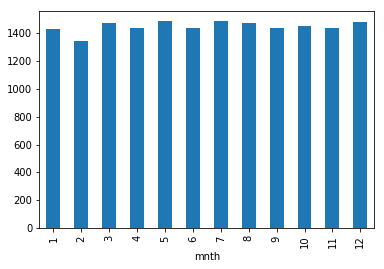

In [322]:
bike_rentals.groupby('mnth').agg('count')['cnt'].plot.bar()

Just making sure that we have data for all months, and it doesn't look like we're missing many days (if any).

# Model Creation

In [323]:
# Make sure that the splits have equal distributions of data per month/year
feature_cols = ['atemp','hr','yr','mnth','year_month', 'windy',
                'season','holiday','weekday','workingday','weathersit','hum','windspeed','time_of_day']
x_train, x_test, y_train, y_test = train_test_split(
    bike_rentals[feature_cols], bike_rentals['cnt'], test_size=0.2, stratify=bike_rentals['year_month']
)

## Linear Regression

MAE train: 105.22108186741931
MSE train: 19899.632378751474
MAE test: 107.11235521477506
MSE test: 20949.858486599594


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2f05a828>,
      dtype=object)

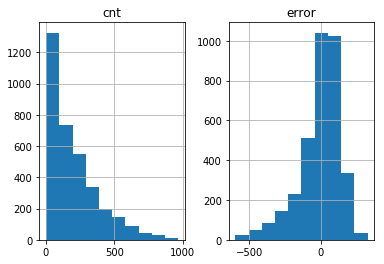

In [324]:
lr = LinearRegression()
lr.fit(x_train, y_train)

predictions = lr.predict(x_train)
mae_train = mean_absolute_error(predictions, y_train)
mse_train = mean_squared_error(predictions, y_train)
print('MAE train: ' + str(mae_train))
print('MSE train: ' + str(mse_train))

predictions = lr.predict(x_test)
mae_test = mean_absolute_error(predictions, y_test)
mse_test = mean_squared_error(predictions, y_test)
print('MAE test: ' + str(mae_test))
print('MSE test: ' + str(mse_test))

combined = pd.DataFrame({'cnt': y_test, 'predicted_count': predictions, 'error': predictions - y_test})
combined[['error','cnt']].hist()

## XGBoost

/Users/jkruger/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:18:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE train: 38.72326178433423
MSE train: 3285.1513357306912
MAE test: 40.857939170602755
MSE test: 3533.560417936258


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2a7fc978>,
      dtype=object)

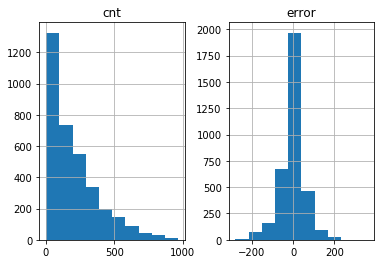

In [325]:
xg = XGBRegressor(n_estimators=200, min_samples_leaf=5)
xg.fit(x_train, y_train)

predictions = xg.predict(x_train)
mae_train = mean_absolute_error(predictions, y_train)
mse_train = mean_squared_error(predictions, y_train)
print('MAE train: ' + str(mae_train))
print('MSE train: ' + str(mse_train))

predictions = xg.predict(x_test)
mae_test = mean_absolute_error(predictions, y_test)
mse_test = mean_squared_error(predictions, y_test)
print('MAE test: ' + str(mae_test))
print('MSE test: ' + str(mse_test))

combined = pd.DataFrame({'cnt': y_test, 'predicted_count': predictions, 'error': predictions - y_test})
combined[['error','cnt']].hist()

## Random Forest

MAE train: 19.88864927784966
MSE train: 1152.3899771320048
MAE test: 27.031594968817025
MSE test: 1882.4319180407144


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2ef46390>,
      dtype=object)

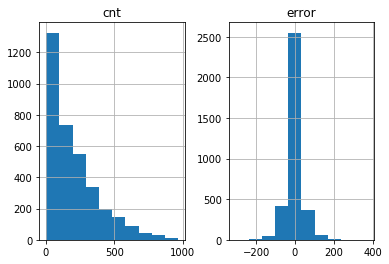

In [326]:
rf = RandomForestRegressor(n_estimators=200, min_samples_leaf=5)
rf.fit(x_train, y_train)

predictions = rf.predict(x_train)
mae_train = mean_absolute_error(predictions, y_train)
mse_train = mean_squared_error(predictions, y_train)
print('MAE train: ' + str(mae_train))
print('MSE train: ' + str(mse_train))

predictions = rf.predict(x_test)
mae_test = mean_absolute_error(predictions, y_test)
mse_test = mean_squared_error(predictions, y_test)
print('MAE test: ' + str(mae_test))
print('MSE test: ' + str(mse_test))

combined = pd.DataFrame({'cnt': y_test, 'predicted_count': predictions, 'error': predictions - y_test})
combined[['error','cnt']].hist()

Random Forest looks like the best algorithm for this problem.